In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
import pandas as pd                                     #reading the data
data = pd.read_csv("spam.csv",encoding="ISO-8859-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data['label'] = np.where(data['v1']=="spam",0,1)

In [6]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,label
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,1
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,0
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,1


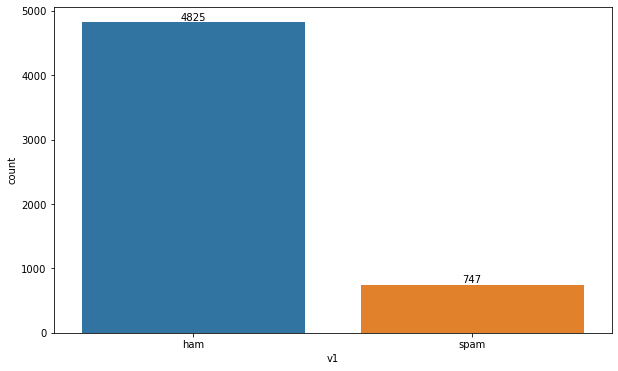

In [7]:
ax = sns.countplot(data = data, x ="v1")
for p in ax.containers:
    ax.bar_label(p)

In [8]:
data.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

# Cleaning Data

In [9]:
data2 = data.copy()

In [10]:
data2.v2.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

# Cleaning Data

In [11]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:
        stop_words.remove(i)

In [12]:
def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [13]:
cleaning_v2 = data2["v2"].apply(cleaning)
cleaning_v2.head()

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts may...
3                  u dun say early hor u c already say
4             nah dont think go usf life around though
Name: v2, dtype: object

# Features and Label

In [14]:
data2 = data2[["v1","label","v2"]]
data2.head()

,v1,label,v2
0,ham,1,"Go until jurong point, crazy.. Available only ..."
1,ham,1,Ok lar... Joking wif u oni...
2,spam,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,1,U dun say so early hor... U c already then say...
4,ham,1,"Nah I don't think he goes to usf, he lives aro..."


# Train Test Split

In [73]:
from sklearn.model_selection import train_test_split

In [126]:
X = data2["v2"]
y= data2["v1"]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

# Vectorization

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

In [129]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # ngram_range=(1,2), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [130]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [131]:
#pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names_out())

# Model Comparisons - Vectorization

In [132]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [133]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))

# Naive Bayes

In [134]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model

In [135]:
nb = MultinomialNB(alpha=3) 
nb.fit(X_train_count,y_train)

MultinomialNB(alpha=3)

In [136]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)

NB MODEL
[[960   6]
 [ 12 137]]
Test_Set
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.96      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3859
        spam       0.94      0.92      0.93       598

    accuracy                           0.98      4457
   macro avg       0.96      0.96      0.96      4457
weighted avg       0.98      0.98      0.98      4457



In [137]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-spam': make_scorer(precision_score, average=None, labels=["spam"]),
            'recall-spam': make_scorer(recall_score, average=None, labels = ["spam"]),
            'f1-spam': make_scorer(f1_score, average=None, labels = ["spam"])}

model = MultinomialNB(alpha=3)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.973077
test_precision-spam    0.901716
test_recall-spam       0.897994
test_f1-spam           0.899517
dtype: float64

In [138]:
nb.classes_

array(['ham', 'spam'], dtype='<U4')

In [139]:
y_pred = nb.predict(X_test_count)   #prediction                                         
nb_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
nb_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [161]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[954  12]
 [ 15 134]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.92      0.90      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       0.97      0.99      0.98       598

    accuracy                           0.99      4457
   macro avg       0.98      0.99      0.99      4457
weighted avg       0.99      0.99      0.99      4457



In [162]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.977562
test_precision-spam    0.925162
test_recall-spam       0.907994
test_f1-spam           0.915660
dtype: float64

# Grid Search 

In [151]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()

penalty = ["l1", "l2"]
C = np.logspace(-1, 5, 20)
class_weight= ["balanced", None] 
# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data
solver = ["liblinear", "sag", "saga"]

param_grid = {"penalty" : penalty,
              "C" : C,
              "class_weight":class_weight,
              "solver":solver}


grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = "recall",   #f1_0 = make_scorer(f1_score, pos_label =0)
                          n_jobs = -1)

In [152]:
grid_model.fit(X_train_count,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'saga']},
             scoring='recall')

In [153]:
grid_model.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

In [163]:
eval(grid_model, X_train_count, X_test_count)

[[922  44]
 [ 21 128]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.95      0.97       966
        spam       0.74      0.86      0.80       149

    accuracy                           0.94      1115
   macro avg       0.86      0.91      0.88      1115
weighted avg       0.95      0.94      0.94      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97      3859
        spam       0.77      0.88      0.82       598

    accuracy                           0.95      4457
   macro avg       0.87      0.92      0.90      4457
weighted avg       0.95      0.95      0.95      4457



In [165]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear', max_iter=1000)
log.fit(X_train_count,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [166]:
print("LOG FINAL MODEL")
eval(log, X_train_count, X_test_count)

LOG FINAL MODEL
[[922  44]
 [ 21 128]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.95      0.97       966
        spam       0.74      0.86      0.80       149

    accuracy                           0.94      1115
   macro avg       0.86      0.91      0.88      1115
weighted avg       0.95      0.94      0.94      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.98      0.96      0.97      3859
        spam       0.77      0.88      0.82       598

    accuracy                           0.95      4457
   macro avg       0.87      0.92      0.90      4457
weighted avg       0.95      0.95      0.95      4457



In [167]:
y_pred = log.predict(X_test_count)   #prediction                                         
log_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
log_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# SVM

In [173]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C =0.1, class_weight= 'balanced', max_iter=1000)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.1, class_weight='balanced')

In [175]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[953  13]
 [ 16 133]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.91      0.89      0.90       149

    accuracy                           0.97      1115
   macro avg       0.95      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       0.97      0.99      0.98       598

    accuracy                           1.00      4457
   macro avg       0.99      0.99      0.99      4457
weighted avg       1.00      1.00      1.00      4457



In [176]:
model = LinearSVC(C=0.1, class_weight= 'balanced', max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.977788
test_precision-spam    0.929208
test_recall-spam       0.904661
test_f1-spam           0.916141
dtype: float64

In [177]:
y_pred = svc.predict(X_test_count)   #prediction                                         
svc_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
svc_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# KNN

In [188]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_count,y_train)

KNeighborsClassifier()

In [189]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[965   1]
 [ 81  68]]
Test_Set
              precision    recall  f1-score   support

         ham       0.92      1.00      0.96       966
        spam       0.99      0.46      0.62       149

    accuracy                           0.93      1115
   macro avg       0.95      0.73      0.79      1115
weighted avg       0.93      0.93      0.91      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      3859
        spam       1.00      0.58      0.74       598

    accuracy                           0.94      4457
   macro avg       0.97      0.79      0.85      4457
weighted avg       0.95      0.94      0.94      4457



In [190]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.917433
test_precision-spam    1.000000
test_recall-spam       0.384633
test_f1-spam           0.553808
dtype: float64

In [191]:
y_pred = knn.predict(X_test_count)   #prediction                                         
knn_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
knn_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 20, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1,
                       random_state=42)

In [197]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL
[[962   4]
 [ 24 125]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.97      0.84      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      3859
        spam       0.98      0.89      0.93       598

    accuracy                           0.98      4457
   macro avg       0.98      0.94      0.96      4457
weighted avg       0.98      0.98      0.98      4457



In [198]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.971056
test_precision-spam    0.993814
test_recall-spam       0.789209
test_f1-spam           0.879072
dtype: float64

In [199]:
y_pred = rf.predict(X_test_count)   #prediction                                         
rf_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
rf_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# Ada Boost

In [201]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [202]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL
[[955  11]
 [ 17 132]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.92      0.89      0.90       149

    accuracy                           0.97      1115
   macro avg       0.95      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [203]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.965227
test_precision-spam    0.883124
test_recall-spam       0.856299
test_f1-spam           0.868362
dtype: float64

In [204]:
y_pred = ada.predict(X_test_count)   #prediction                                         
ada_count_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
ada_count_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# TF-IDF

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [206]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3) #min_df genelde 3 olmalı(corpusta en az 3 defa geçenler yoksay)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [207]:
X_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [208]:
#pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names_out())

# Model Comparisons TF-IDF

# Naive Bayes

In [211]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

MultinomialNB()

In [212]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[964   2]
 [ 29 120]]
Test_Set
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      3859
        spam       0.99      0.85      0.92       598

    accuracy                           0.98      4457
   macro avg       0.99      0.92      0.95      4457
weighted avg       0.98      0.98      0.98      4457



In [213]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.974423
test_precision-spam    0.988234
test_recall-spam       0.819379
test_f1-spam           0.895567
dtype: float64

In [214]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
nb_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# Logistic Regression

In [215]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear', max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [216]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[905  61]
 [ 28 121]]
Test_Set
              precision    recall  f1-score   support

         ham       0.97      0.94      0.95       966
        spam       0.66      0.81      0.73       149

    accuracy                           0.92      1115
   macro avg       0.82      0.87      0.84      1115
weighted avg       0.93      0.92      0.92      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.97      0.94      0.95      3859
        spam       0.67      0.82      0.74       598

    accuracy                           0.92      4457
   macro avg       0.82      0.88      0.84      4457
weighted avg       0.93      0.92      0.92      4457



In [217]:
model = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear', max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.916761
test_precision-spam    0.657241
test_recall-spam       0.806045
test_f1-spam           0.722485
dtype: float64

In [218]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
log_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# SVM

In [219]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1, class_weight= 'balanced', max_iter=1000)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1, class_weight='balanced')

In [220]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[957   9]
 [ 12 137]]
Test_Set
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.94      0.92      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      3859
        spam       0.92      0.98      0.95       598

    accuracy                           0.99      4457
   macro avg       0.96      0.98      0.97      4457
weighted avg       0.99      0.99      0.99      4457



In [221]:
model = LinearSVC(C=0.1, class_weight= 'balanced', max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.975546
test_precision-spam    0.906683
test_recall-spam       0.914746
test_f1-spam           0.909641
dtype: float64

In [241]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
svc_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# KNN

In [224]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(weights='distance')

In [225]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[966   0]
 [ 62  87]]
Test_Set
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       966
        spam       1.00      0.58      0.74       149

    accuracy                           0.94      1115
   macro avg       0.97      0.79      0.85      1115
weighted avg       0.95      0.94      0.94      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [226]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.913395
test_precision-spam    1.000000
test_recall-spam       0.354548
test_f1-spam           0.521683
dtype: float64

In [228]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
knn_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# RandomForest

In [231]:
rf = RandomForestClassifier(100, max_depth = 20, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1,
                       random_state=42)

In [232]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[962   4]
 [ 25 124]]
Test_Set
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       0.97      0.83      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      3859
        spam       0.99      0.89      0.94       598

    accuracy                           0.98      4457
   macro avg       0.99      0.94      0.96      4457
weighted avg       0.98      0.98      0.98      4457



In [233]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.972178
test_precision-spam    0.988104
test_recall-spam       0.802599
test_f1-spam           0.885224
dtype: float64

In [234]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
rf_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)

# Ada Boost

In [235]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [236]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[959   7]
 [ 23 126]]
Test_Set
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       966
        spam       0.95      0.85      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Train_Set
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [237]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy          0.970159
test_precision-spam    0.940701
test_recall-spam       0.831130
test_f1-spam           0.881752
dtype: float64

In [238]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_spam = recall_score(y_test, y_pred, labels = ["spam"], average = None)
ada_tfidf_f1_spam = f1_score(y_test, y_pred, labels = ["spam"], average = None)


# Compare the performance of the models

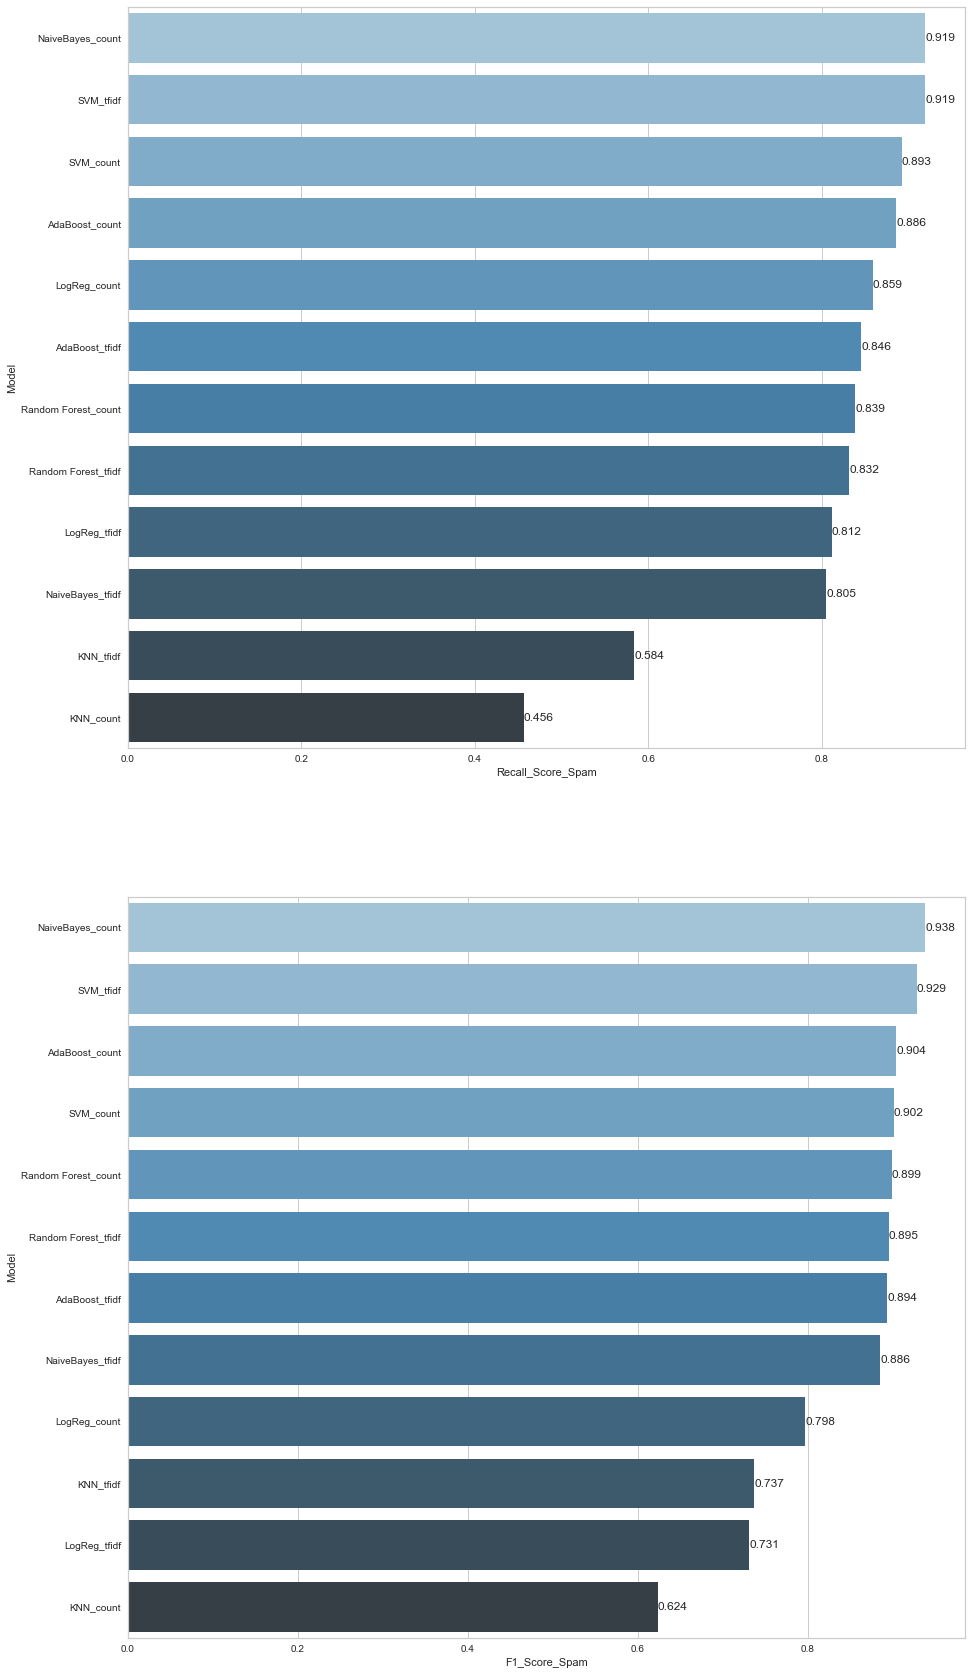

In [242]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],
                        
                        "F1_Score_Spam": [nb_count_f1_spam[0], log_count_f1_spam[0], svc_count_f1_spam[0], knn_count_f1_spam[0],
                                             rf_count_f1_spam[0], ada_count_f1_spam[0], nb_tfidf_f1_spam[0], log_tfidf_f1_spam[0],
                                             svc_tfidf_f1_spam[0], knn_tfidf_f1_spam[0], rf_tfidf_f1_spam[0], ada_tfidf_f1_spam[0]],
                        
                        "Recall_Score_Spam": [nb_count_rec_spam[0], log_count_rec_spam[0], svc_count_rec_spam[0], 
                                                  knn_count_rec_spam[0], rf_count_rec_spam[0], ada_count_rec_spam[0], 
                                                  nb_tfidf_rec_spam[0], log_tfidf_rec_spam[0], svc_tfidf_rec_spam[0], 
                                                  knn_tfidf_rec_spam[0], rf_tfidf_rec_spam[0], ada_tfidf_rec_spam[0]]
                        
              })

def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(15,30))
plt.subplot(211)
compare = compare.sort_values(by="Recall_Score_Spam", ascending=False)
ax=sns.barplot(x="Recall_Score_Spam", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(212)
compare = compare.sort_values(by="F1_Score_Spam", ascending=False)
ax=sns.barplot(x="F1_Score_Spam", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show();

# For New Message, prediction with pipeline

In [243]:
from sklearn.pipeline import Pipeline

In [244]:
pipe = Pipeline([('count',CountVectorizer(preprocessor=cleaning, min_df=3)),('np',MultinomialNB(alpha=3) )])

In [245]:
pipe.fit(X, y)

Pipeline(steps=[('count',
                 CountVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x0000021E6669B550>)),
                ('np', MultinomialNB(alpha=3))])

In [246]:
message = "it was not the worst flight i have ever been"
message = pd.Series(message)
pipe.predict(message)

array(['ham'], dtype='<U4')

In [253]:
message = "FREE for 1st week!"
message = pd.Series(message)
pipe.predict(message)

array(['spam'], dtype='<U4')

In [17]:
from wordcloud import WordCloud
import re

In [21]:
from collections import Counter
all_words =Counter(" ".join(cleaning_v2).split()).most_common(100)

In [22]:
all_words = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(all_words))

In [23]:
all_words

'   u            call           im           not           get           ur           no           lt           go           free           dont           know           ok           come           got           like           good           day           time           text           want           love           ill           send           one           need           today           going           r           txt           home           lor           sorry           see           still           back           stop           c           mobile           take           da           n           reply           think           tell           phone           well           new           later           week           hi           please           cant           pls           make           night           say           dear           claim           message           thing           great           k           much           oh           hope           number           na           w

In [24]:
worldcloud = WordCloud(background_color="white", max_words =250)

In [25]:
worldcloud.generate(all_words)

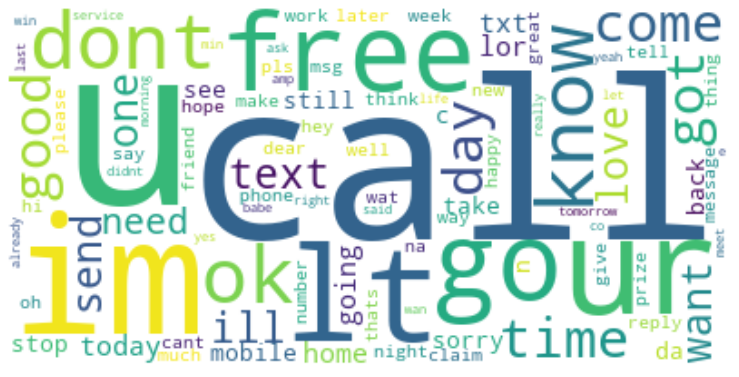

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear",)
plt.axis("off")
plt.show()